# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [4]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.152315 -0.008257  0.124823 -0.438372 -0.115707 -0.225058   
      201547 -0.429644 -0.180829  0.091231  0.321699  0.151782  0.138723   
      201548 -0.161068  0.576082 -0.436528  0.165498  0.241237  0.042973   
      201549 -0.260170  0.167611 -0.410230  0.064991  0.048733  0.131852   
      201550  0.441330  0.225024 -0.081751 -0.672187  0.065666 -0.758178   

                     6         7         8         9  ...      1015      1016  \
41001 201546 -0.473106 -0.368344 -0.407803  0.184894  ... -0.078890  0.103824   
      201547 -0.128355 -0.300411  0.658483 -0.437008  ...  0.314439  0.368487   
      201548  0.055301 -0.306384 -0.244395  0.053250  ...  0.455030 -0.227580   
      201549 -0.398770 -0.091087  0.217093 -0.104882  ... -0.287345  0.278916   
      201550  0.085061 -0.633349  0.213285  0.176507  ...  0.162102 -0.204953   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  0.726407 -0.460573 -0.098291 -0.444475  0.310875  0.038217   
      201547  0.963722  0.200345 -0.157422 -0.599799 -0.170341 -0.038084   
      201548 -0.136099 -0.016585  0.391008  0.751067  0.211474  0.286467   
      201549  0.106186  0.005580  0.201473 -0.214119  0.614926 -0.359967   
      201550  0.413980 -0.400370 -0.097594 -0.198839 -0.752909 -0.144777   

                  1023    Labels  
41001 201546  0.056886 -0.861740  
      201547 -0.595335 -0.854589  
      201548 -0.406842 -0.856973  
      201549  0.149468 -0.856973  
      201550  0.328874 -0.823600  

[5 rows x 1025 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4         5  \
5360 201546  0.186118 -0.467990  0.435267  0.347558  0.223379 -0.092600   
     201547 -0.031743  0.128215 -0.254998  0.266815 -0.474168 -0.156857   
     201548 -0.109709  0.166347 -0.013395 -0.174514 -0.390162 -0.349858   
     201549  0.359992  0.546292  0.127535 -0.222885 -0.547900 -0.011747   
     201550  0.137245 -0.345681 -0.045487 -0.131272 -0.013486  0.008818   

                    6         7         8         9  ...      1015      1016  \
5360 201546  0.222575 -0.090122 -0.288593  0.422614  ...  0.060105  0.443189   
     201547 -0.358710 -0.129209 -0.221991  0.871192  ... -0.279091  0.047074   
     201548 -0.130038 -0.177032  0.483901  0.582196  ...  0.597011  0.044982   
     201549 -0.106706  0.215504  0.036656  0.341239  ... -0.498720 -0.400292   
     201550  0.253216 -0.028422 -0.046990 -0.039587  ...  0.253952  0.262296   

                 1017      1018      1019      1020      1021      1022  \
5360 201546  0.036510 -0.045586 -0.175214 -0.099030 -0.193360 -0.066682   
     201547  0.327831  0.101820 -0.175938  0.752862  0.237860 -0.738861   
     201548  0.273295 -0.035685 -0.085753 -0.327600  0.082075 -0.375873   
     201549  0.091562  0.163436 -0.452942  0.085359 -0.203362 -0.128735   
     201550 -0.078173 -0.191487  0.303004 -0.286701 -0.399233 -0.221834   

                 1023    Labels  
5360 201546 -0.025980 -0.990465  
     201547 -0.068780 -0.969011  
     201548  0.414215 -0.995232  
     201549 -0.053798 -0.997616  
     201550 -0.209901 -0.971395  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(161, 3073)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [10]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1288, 3072)
The shape of the labels is (1288, 1)
Test:
The shape of the features is (322, 3072)
The shape of the labels is (322, 1)


In [11]:
# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1288, 3072)
The test shape is (322, 3072)
-----------------------
The Final shapes are:
The train shape is (1288, 3, 1024)
The test shape is (322, 3, 1024)


# 2. Model

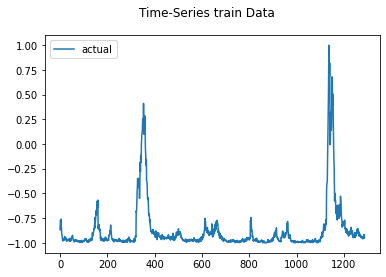

2023-03-06 20:58:41.084524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 20:58:41.084569: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 20:58:41.084606: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-06 20:58:41.086694: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 20:58:42.638418: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 47.313
Test RMSE: 52.918
Test sMAPE: 127.936
Test R Squared: -1.717
{'mae': 47.313235013381295, 'rmse': 52.91784393998618, 'smape': 127.93585298325743, 'r2': -1.7168289542213118}


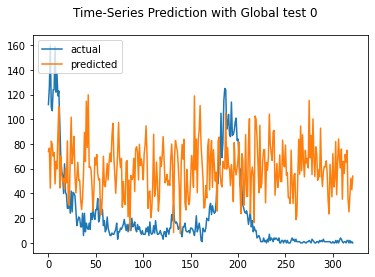

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 40.884
Test RMSE: 51.608
Test sMAPE: 128.315
Test R Squared: -1.584
{'mae': 40.88351317416437, 'rmse': 51.607572663019624, 'smape': 128.31504344177714, 'r2': -1.5839546074162074}


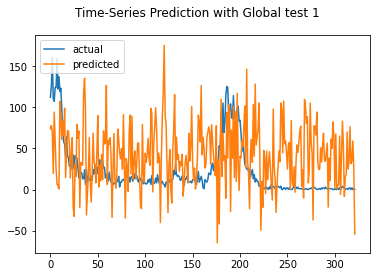

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 47.380
Test RMSE: 55.473
Test sMAPE: 129.649
Test R Squared: -1.986
{'mae': 47.38008854274424, 'rmse': 55.47345219515059, 'smape': 129.64908977632612, 'r2': -1.9855778611632062}


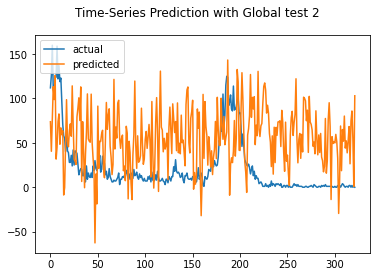

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 40.942
Test RMSE: 50.287
Test sMAPE: 129.749
Test R Squared: -1.453
{'mae': 40.94248990325824, 'rmse': 50.286901323532675, 'smape': 129.7492249472172, 'r2': -1.45339663420704}


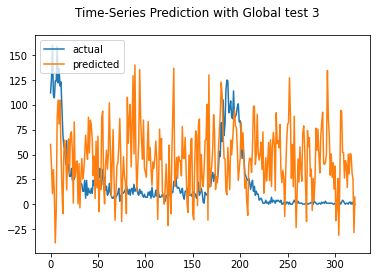

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 48.996
Test RMSE: 60.712
Test sMAPE: 147.920
Test R Squared: -2.576
{'mae': 48.99606628836312, 'rmse': 60.711685877956974, 'smape': 147.91995354484862, 'r2': -2.5760419123695013}


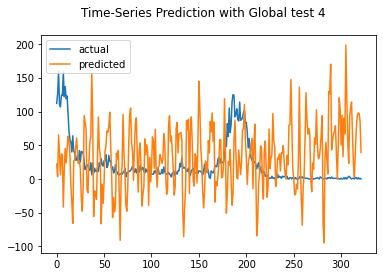

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 42.674
Test RMSE: 49.307
Test sMAPE: 127.925
Test R Squared: -1.359
{'mae': 42.6742537265979, 'rmse': 49.30704887291578, 'smape': 127.92510765819341, 'r2': -1.3587180715993616}


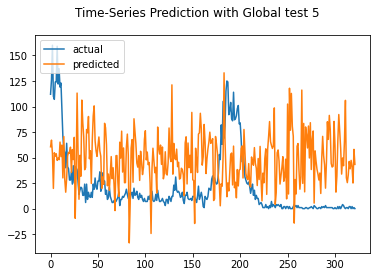

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 48.497
Test RMSE: 57.810
Test sMAPE: 133.985
Test R Squared: -2.242
{'mae': 48.496724059215246, 'rmse': 57.810000587127696, 'smape': 133.98540423822791, 'r2': -2.242380375873551}


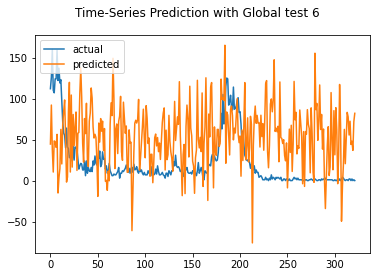

Test MAE: 42.828
Test RMSE: 46.783
Test sMAPE: 126.292
Test R Squared: -1.123
{'mae': 42.828383816695364, 'rmse': 46.782508356029126, 'smape': 126.2919965463429, 'r2': -1.1233667984325648}


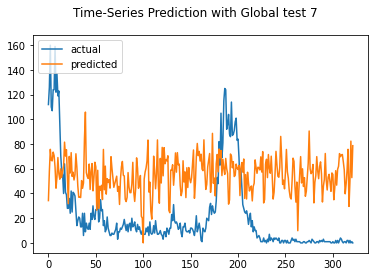

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 39.984
Test RMSE: 50.817
Test sMAPE: 130.509
Test R Squared: -1.505
{'mae': 39.98376398871404, 'rmse': 50.816578023950605, 'smape': 130.50873966600477, 'r2': -1.5053525477770666}


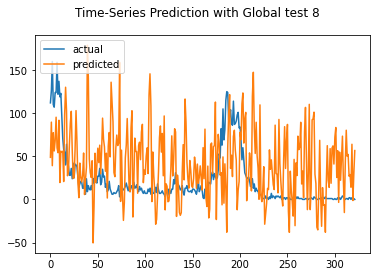

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 34.858
Test RMSE: 44.934
Test sMAPE: 145.621
Test R Squared: -0.959
{'mae': 34.85809811977496, 'rmse': 44.934476800648916, 'smape': 145.6212485379421, 'r2': -0.95892312574107}


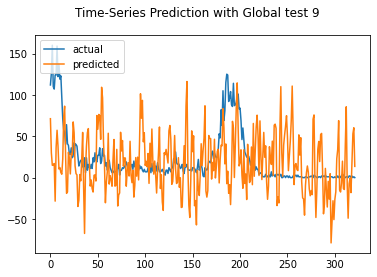

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 41.172
Test RMSE: 48.104
Test sMAPE: 125.168
Test R Squared: -1.245
{'mae': 41.171572437937954, 'rmse': 48.1037503304272, 'smape': 125.16814388057762, 'r2': -1.2449976367167257}


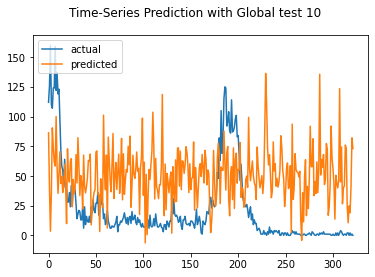

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 38.041
Test RMSE: 44.996
Test sMAPE: 125.206
Test R Squared: -0.964
{'mae': 38.041031228644506, 'rmse': 44.9963972340604, 'smape': 125.20634612933577, 'r2': -0.964325700889284}


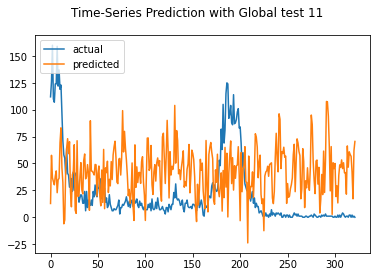

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 40.825
Test RMSE: 52.387
Test sMAPE: 144.527
Test R Squared: -1.663
{'mae': 40.82459083606738, 'rmse': 52.38708680444624, 'smape': 144.52651165426084, 'r2': -1.6626035793500407}


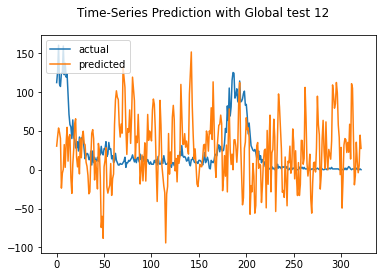

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 45.245
Test RMSE: 55.407
Test sMAPE: 141.102
Test R Squared: -1.978
{'mae': 45.24504281904387, 'rmse': 55.40705861910586, 'smape': 141.10224942762548, 'r2': -1.9784355413364008}


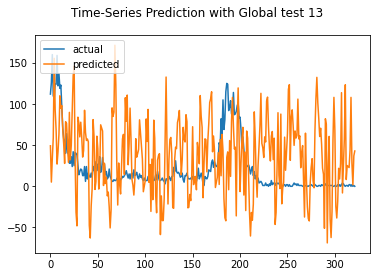

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 35.292
Test RMSE: 42.333
Test sMAPE: 121.740
Test R Squared: -0.739
{'mae': 35.291518271339605, 'rmse': 42.33314906647939, 'smape': 121.74012846884895, 'r2': -0.7386780298497544}


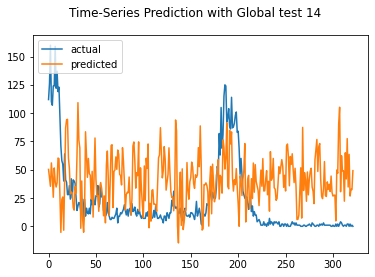

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 37.997
Test RMSE: 50.194
Test sMAPE: 137.988
Test R Squared: -1.444
{'mae': 37.996507287580776, 'rmse': 50.19434806905513, 'smape': 137.98798314265963, 'r2': -1.4443739712253811}


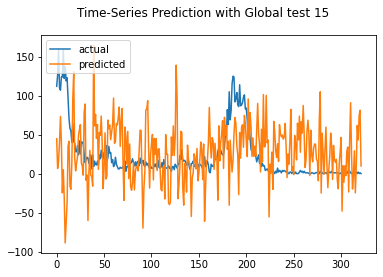

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 36.668
Test RMSE: 45.771
Test sMAPE: 130.496
Test R Squared: -1.033
{'mae': 36.66777876510013, 'rmse': 45.77077070993026, 'smape': 130.49591969068814, 'r2': -1.0325183039427364}


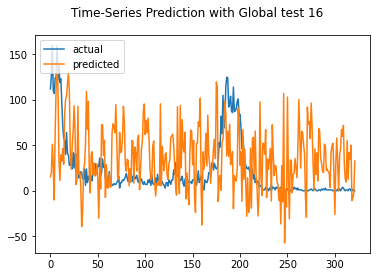

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 43.361
Test RMSE: 51.855
Test sMAPE: 128.439
Test R Squared: -1.609
{'mae': 43.36129742175896, 'rmse': 51.85534695754521, 'smape': 128.43850612927022, 'r2': -1.6088259364219395}


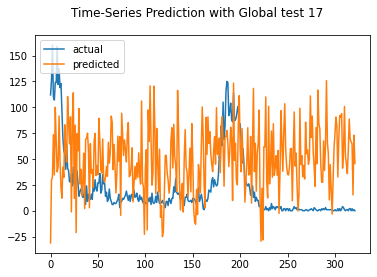

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 46.388
Test RMSE: 55.695
Test sMAPE: 128.800
Test R Squared: -2.009
{'mae': 46.38837806084511, 'rmse': 55.6948668700009, 'smape': 128.800081023777, 'r2': -2.0094584733067125}


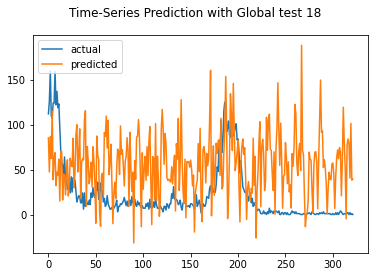

Test MAE: 41.221
Test RMSE: 50.132
Test sMAPE: 128.481
Test R Squared: -1.438
{'mae': 41.220524081902475, 'rmse': 50.132124454550436, 'smape': 128.48120809169203, 'r2': -1.4383173726145704}


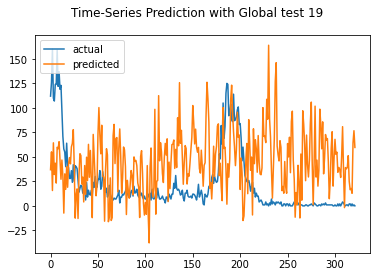

Test MAE: 78.435
Test RMSE: 99.653
Test sMAPE: 155.833
Test R Squared: -8.635
{'mae': 78.43470995988905, 'rmse': 99.65260512932514, 'smape': 155.8334728992433, 'r2': -8.634636360963022}


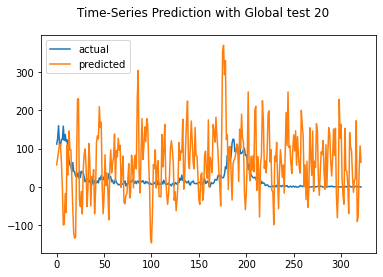

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 34.916
Test RMSE: 43.160
Test sMAPE: 127.834
Test R Squared: -0.807
{'mae': 34.915525797638836, 'rmse': 43.160151661552014, 'smape': 127.83429610597328, 'r2': -0.8072737423811007}


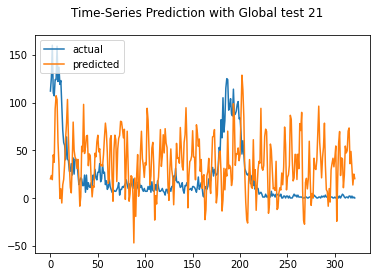

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 39.908
Test RMSE: 47.679
Test sMAPE: 125.550
Test R Squared: -1.206
{'mae': 39.908123718100306, 'rmse': 47.679357948373855, 'smape': 125.55041603763046, 'r2': -1.205559669597108}


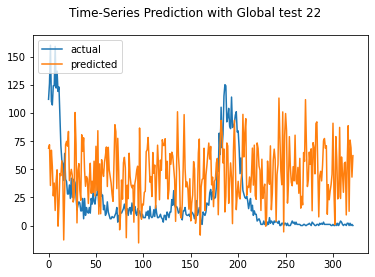

Test MAE: 47.957
Test RMSE: 52.859
Test sMAPE: 130.092
Test R Squared: -1.711
{'mae': 47.957173113497156, 'rmse': 52.85896959696012, 'smape': 130.09164508679012, 'r2': -1.710787039813642}


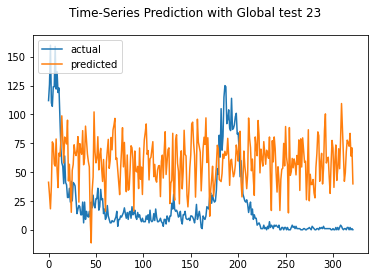

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 37.084
Test RMSE: 47.244
Test sMAPE: 142.622
Test R Squared: -1.165
{'mae': 37.084166259684174, 'rmse': 47.244362970658784, 'smape': 142.62162799538072, 'r2': -1.1654991100292147}


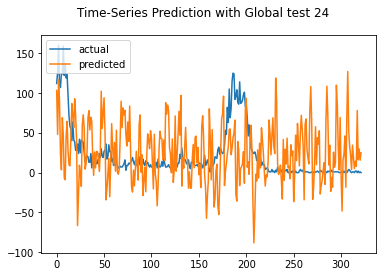

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 50.741
Test RMSE: 58.683
Test sMAPE: 130.386
Test R Squared: -2.341
{'mae': 50.74055939116833, 'rmse': 58.68342049506968, 'smape': 130.38575655176422, 'r2': -2.34109522832527}


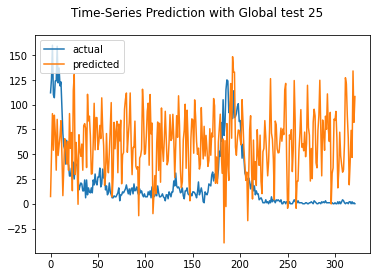

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 39.538
Test RMSE: 48.458
Test sMAPE: 125.208
Test R Squared: -1.278
{'mae': 39.538146226580096, 'rmse': 48.457512178224114, 'smape': 125.20766975087196, 'r2': -1.2781391201439076}


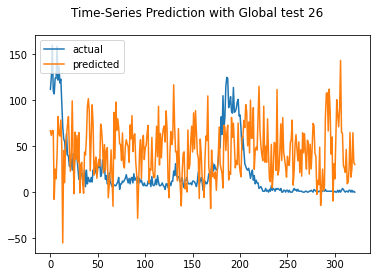

Test MAE: 48.649
Test RMSE: 54.183
Test sMAPE: 129.138
Test R Squared: -1.848
{'mae': 48.64945469287612, 'rmse': 54.18330812142511, 'smape': 129.13764087279318, 'r2': -1.8483217666046672}


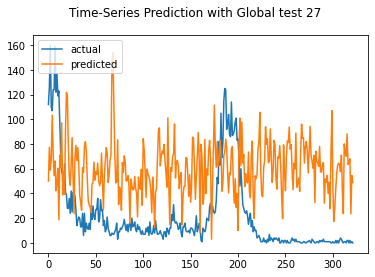

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 42.042
Test RMSE: 51.569
Test sMAPE: 134.556
Test R Squared: -1.580
{'mae': 42.042268491679835, 'rmse': 51.56880862349825, 'smape': 134.55601897769583, 'r2': -1.5800742892757849}


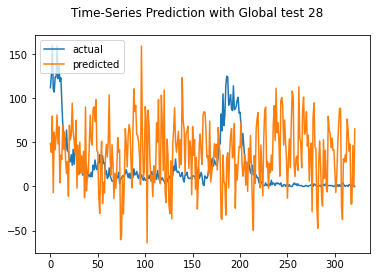

Test MAE: 44.397
Test RMSE: 49.962
Test sMAPE: 126.522
Test R Squared: -1.422
{'mae': 44.39731822926436, 'rmse': 49.96231342638168, 'smape': 126.52227064850723, 'r2': -1.421826871577998}


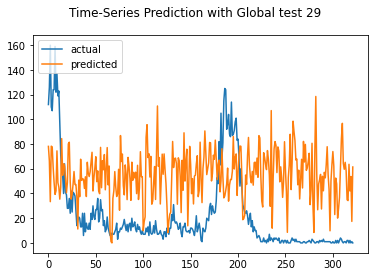

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 43.705
Test RMSE: 54.311
Test sMAPE: 137.122
Test R Squared: -1.862
{'mae': 43.70536401071904, 'rmse': 54.31106437702119, 'smape': 137.12196744205832, 'r2': -1.861769447702454}


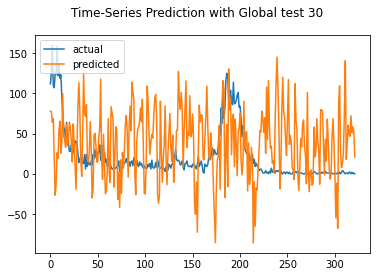

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 43.080
Test RMSE: 51.697
Test sMAPE: 123.409
Test R Squared: -1.593
{'mae': 43.080226058915535, 'rmse': 51.6967574919652, 'smape': 123.40943987969484, 'r2': -1.5928931666887034}


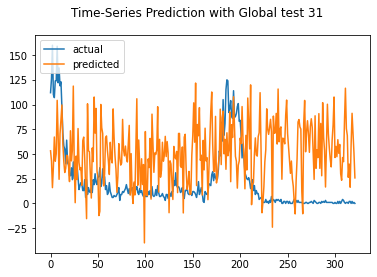

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 40.928
Test RMSE: 49.646
Test sMAPE: 122.970
Test R Squared: -1.391
{'mae': 40.92791768575307, 'rmse': 49.645958994022855, 'smape': 122.96957536554682, 'r2': -1.3912546255309355}


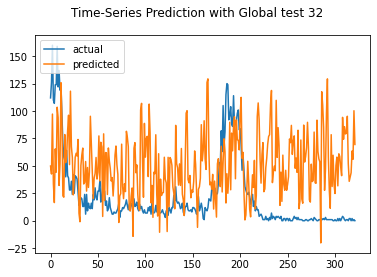

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 44.125
Test RMSE: 54.173
Test sMAPE: 133.724
Test R Squared: -1.847
{'mae': 44.12486275752879, 'rmse': 54.17282643033363, 'smape': 133.7236025390317, 'r2': -1.847219864849535}


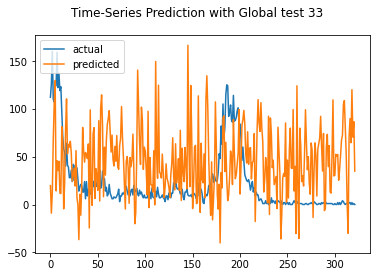

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 42.505
Test RMSE: 52.207
Test sMAPE: 125.381
Test R Squared: -1.644
{'mae': 42.504957209832924, 'rmse': 52.206550096608936, 'smape': 125.38106229641376, 'r2': -1.6442834389462786}


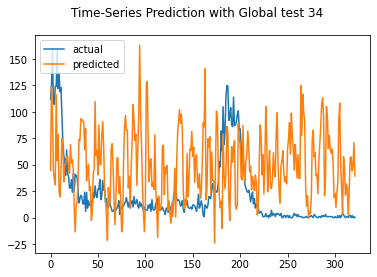

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 31.069
Test RMSE: 43.984
Test sMAPE: 152.262
Test R Squared: -0.877
{'mae': 31.069285444406248, 'rmse': 43.98390946990192, 'smape': 152.2619716507653, 'r2': -0.876919610191506}


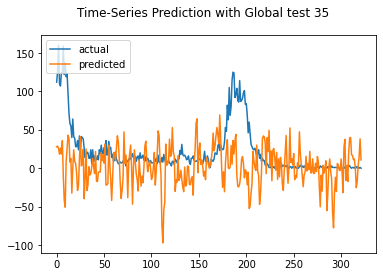

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 43.043
Test RMSE: 51.717
Test sMAPE: 133.569
Test R Squared: -1.595
{'mae': 43.04283169930026, 'rmse': 51.71723699951115, 'smape': 133.56854807376027, 'r2': -1.5949479065091992}


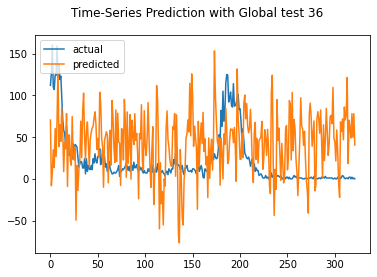

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 42.719
Test RMSE: 49.774
Test sMAPE: 127.788
Test R Squared: -1.404
{'mae': 42.71888933881469, 'rmse': 49.77404696666893, 'smape': 127.78801294864513, 'r2': -1.403609551608612}


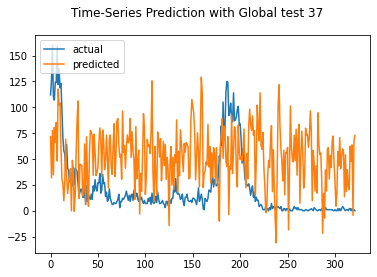

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 44.037
Test RMSE: 52.329
Test sMAPE: 129.369
Test R Squared: -1.657
{'mae': 44.03683718502151, 'rmse': 52.32853970827051, 'smape': 129.3687578581533, 'r2': -1.6566555257990614}


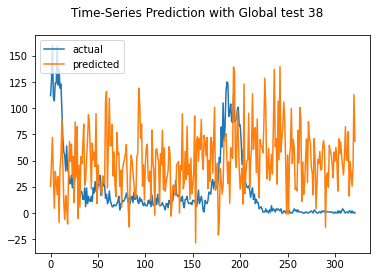

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 41.691
Test RMSE: 54.128
Test sMAPE: 153.509
Test R Squared: -1.843
{'mae': 41.69129302551657, 'rmse': 54.12813749442406, 'smape': 153.50896114584236, 'r2': -1.842524272887938}


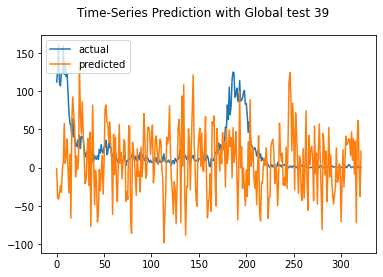

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 37.936
Test RMSE: 49.150
Test sMAPE: 144.768
Test R Squared: -1.344
{'mae': 37.93571714334976, 'rmse': 49.1496600837237, 'smape': 144.76753950381774, 'r2': -1.3436839823603854}


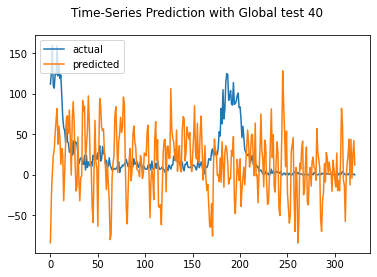

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 44.770
Test RMSE: 54.221
Test sMAPE: 130.777
Test R Squared: -1.852
{'mae': 44.769563901405895, 'rmse': 54.22118900730294, 'smape': 130.77736883760102, 'r2': -1.8523058226630784}


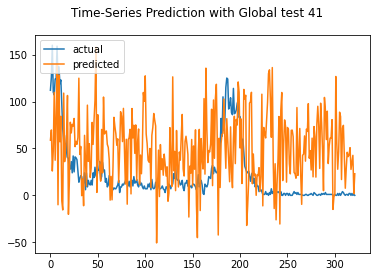

Test MAE: 49.221
Test RMSE: 54.627
Test sMAPE: 129.942
Test R Squared: -1.895
{'mae': 49.220538068261945, 'rmse': 54.62703034685486, 'smape': 129.9419848625232, 'r2': -1.8951641903367018}


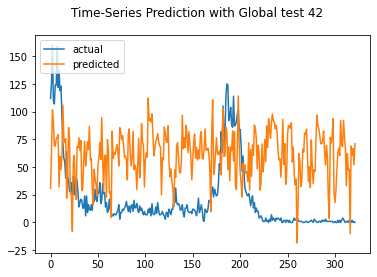

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 43.823
Test RMSE: 52.432
Test sMAPE: 136.060
Test R Squared: -1.667
{'mae': 43.82311422576815, 'rmse': 52.43200927831304, 'smape': 136.05956514184373, 'r2': -1.6671719579616138}


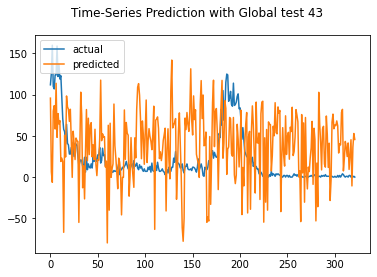

Test MAE: 56.080
Test RMSE: 75.244
Test sMAPE: 158.824
Test R Squared: -4.493
{'mae': 56.07970238065127, 'rmse': 75.24428851284407, 'smape': 158.8238057827888, 'r2': -4.492943028436948}


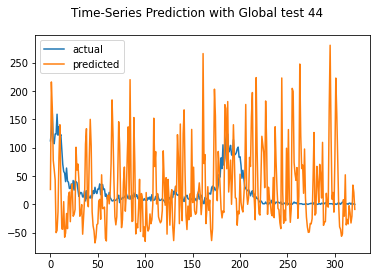

Test MAE: 50.940
Test RMSE: 56.817
Test sMAPE: 130.858
Test R Squared: -2.132
{'mae': 50.94016769361792, 'rmse': 56.81659232340019, 'smape': 130.85773821149877, 'r2': -2.13190355535094}


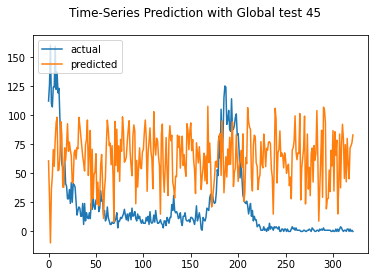

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 39.676
Test RMSE: 51.219
Test sMAPE: 143.397
Test R Squared: -1.545
{'mae': 39.67596465312176, 'rmse': 51.21876444816108, 'smape': 143.39744707402485, 'r2': -1.5451665694068017}


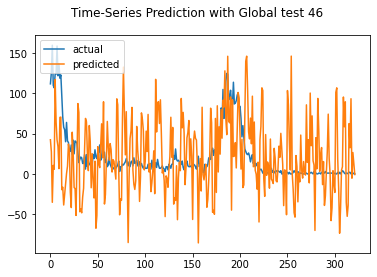

Test MAE: 45.235
Test RMSE: 50.063
Test sMAPE: 126.986
Test R Squared: -1.432
{'mae': 45.23496132607786, 'rmse': 50.06268218109884, 'smape': 126.98611364607429, 'r2': -1.431567009161021}


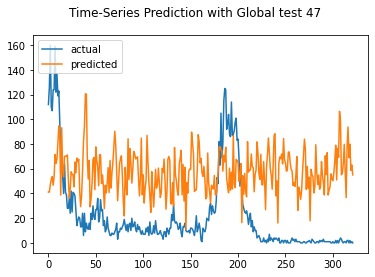

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 41.412
Test RMSE: 50.088
Test sMAPE: 130.263
Test R Squared: -1.434
{'mae': 41.41220712615466, 'rmse': 50.08754607252975, 'smape': 130.26255430416472, 'r2': -1.4339829097453403}


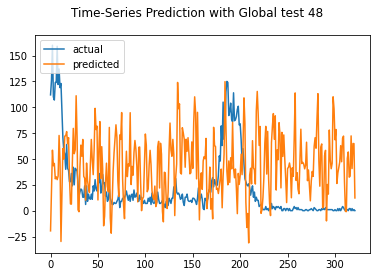

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 42.874
Test RMSE: 54.260
Test sMAPE: 137.820
Test R Squared: -1.856
{'mae': 42.87358293474091, 'rmse': 54.259975612099076, 'smape': 137.8201734266244, 'r2': -1.856388021162584}


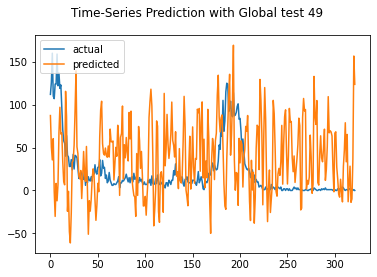

Test MAE: 48.339
Test RMSE: 52.229
Test sMAPE: 131.044
Test R Squared: -1.647
{'mae': 48.33916478127427, 'rmse': 52.22863616641457, 'smape': 131.04400517038428, 'r2': -1.6465212494128498}


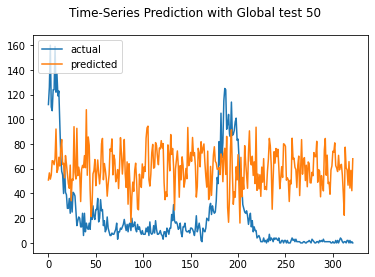

Test MAE: 47.906
Test RMSE: 52.775
Test sMAPE: 129.859
Test R Squared: -1.702
{'mae': 47.90580668212464, 'rmse': 52.77454788946957, 'smape': 129.85935719101818, 'r2': -1.702135092062787}


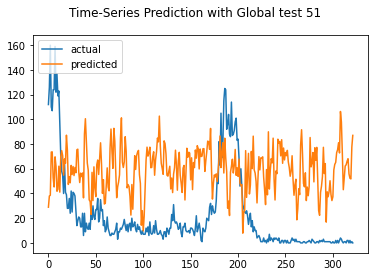

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 45.445
Test RMSE: 51.471
Test sMAPE: 126.543
Test R Squared: -1.570
{'mae': 45.444679723763315, 'rmse': 51.47121782581692, 'smape': 126.54259494942329, 'r2': -1.5703182656361818}


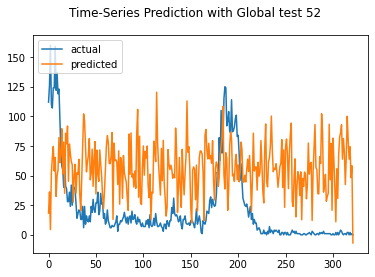

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 42.184
Test RMSE: 51.268
Test sMAPE: 136.672
Test R Squared: -1.550
{'mae': 42.184087260539485, 'rmse': 51.26821498446474, 'smape': 136.67234607076284, 'r2': -1.5500835411685663}


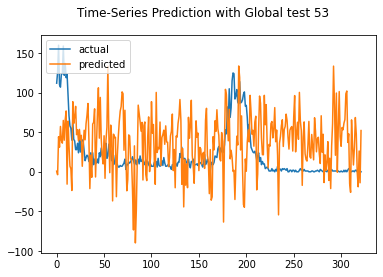

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 43.962
Test RMSE: 50.952
Test sMAPE: 128.243
Test R Squared: -1.519
{'mae': 43.96222644859219, 'rmse': 50.95234966010739, 'smape': 128.24335258392026, 'r2': -1.518758024557842}


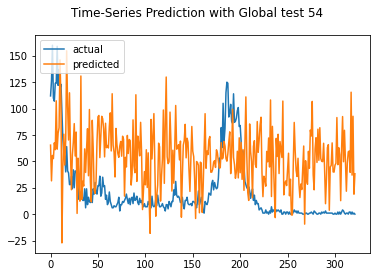

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 44.050
Test RMSE: 54.493
Test sMAPE: 131.283
Test R Squared: -1.881
{'mae': 44.05034213850957, 'rmse': 54.49274609423254, 'smape': 131.28343479959284, 'r2': -1.8809478906974277}


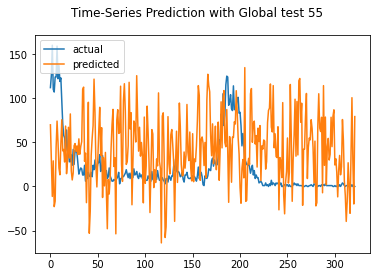

Test MAE: 39.574
Test RMSE: 46.038
Test sMAPE: 121.751
Test R Squared: -1.056
{'mae': 39.5737868436375, 'rmse': 46.03779318833921, 'smape': 121.75145783665332, 'r2': -1.0563025303996616}


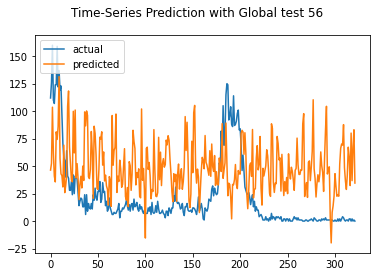

Test MAE: 44.692
Test RMSE: 49.166
Test sMAPE: 126.926
Test R Squared: -1.345
{'mae': 44.69156129315773, 'rmse': 49.1659955841294, 'smape': 126.92623981190863, 'r2': -1.3452421462568962}


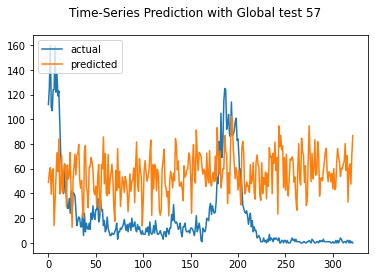

Test MAE: 46.420
Test RMSE: 51.276
Test sMAPE: 128.014
Test R Squared: -1.551
{'mae': 46.419684564104735, 'rmse': 51.27617123580612, 'smape': 128.0137001532879, 'r2': -1.5508750912516684}


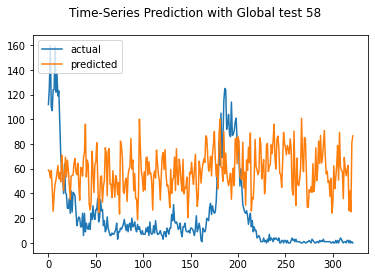

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 49.630
Test RMSE: 61.079
Test sMAPE: 148.090
Test R Squared: -2.619
{'mae': 49.630140337699686, 'rmse': 61.078502347560956, 'smape': 148.09049473593694, 'r2': -2.6193849298528904}


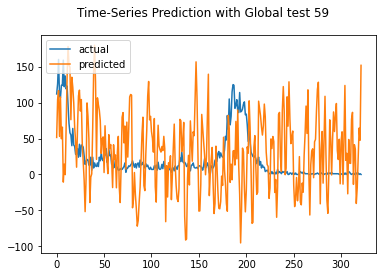

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 47.385
Test RMSE: 54.725
Test sMAPE: 128.465
Test R Squared: -1.906
{'mae': 47.38525059171345, 'rmse': 54.725413210226854, 'smape': 128.46457402622303, 'r2': -1.9056019180909893}


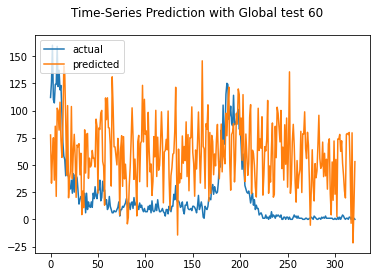

Test MAE: 46.054
Test RMSE: 50.831
Test sMAPE: 128.210
Test R Squared: -1.507
{'mae': 46.054304060728654, 'rmse': 50.830507437234495, 'smape': 128.21045284963947, 'r2': -1.5067262283908653}


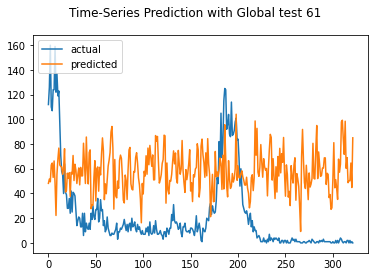

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 40.427
Test RMSE: 51.070
Test sMAPE: 134.343
Test R Squared: -1.530
{'mae': 40.42707628807666, 'rmse': 51.06998352299833, 'smape': 134.343425818761, 'r2': -1.5304015802480957}


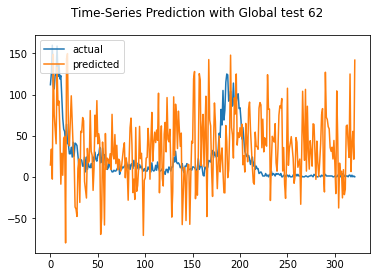

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 44.682
Test RMSE: 52.078
Test sMAPE: 127.451
Test R Squared: -1.631
{'mae': 44.68155139092333, 'rmse': 52.07781119012608, 'smape': 127.45092273162527, 'r2': -1.6312581605018983}


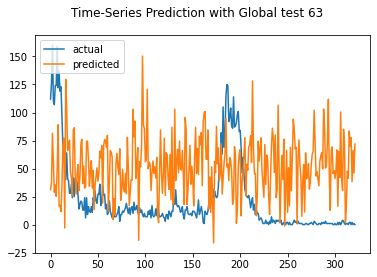

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 45.244
Test RMSE: 53.916
Test sMAPE: 128.031
Test R Squared: -1.820
{'mae': 45.243775330715295, 'rmse': 53.91620538365809, 'smape': 128.03132455207526, 'r2': -1.8203087361383439}


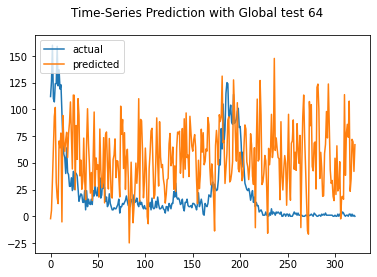

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 42.783
Test RMSE: 50.072
Test sMAPE: 127.684
Test R Squared: -1.432
{'mae': 42.78276377435056, 'rmse': 50.07176864117353, 'smape': 127.68414640942858, 'r2': -1.4324497561759393}


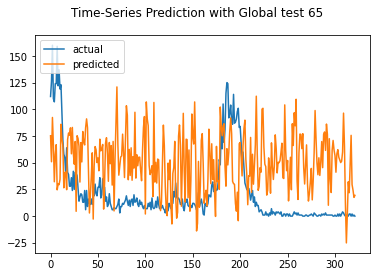

Test MAE: 51.532
Test RMSE: 58.117
Test sMAPE: 130.418
Test R Squared: -2.277
{'mae': 51.53194573503103, 'rmse': 58.11734897589434, 'smape': 130.41842566087266, 'r2': -2.2769484243332827}


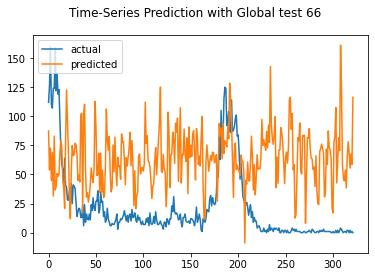

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 45.628
Test RMSE: 53.002
Test sMAPE: 125.091
Test R Squared: -1.725
{'mae': 45.62849409535805, 'rmse': 53.001776999170204, 'smape': 125.09083855386938, 'r2': -1.7254541206737488}


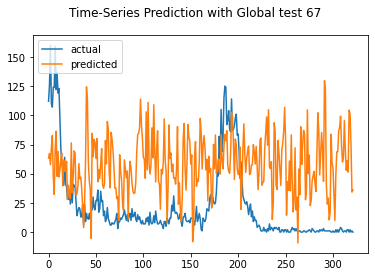

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 38.664
Test RMSE: 47.376
Test sMAPE: 125.487
Test R Squared: -1.178
{'mae': 38.663929482054264, 'rmse': 47.375681325816295, 'smape': 125.48679509077282, 'r2': -1.1775540928543435}


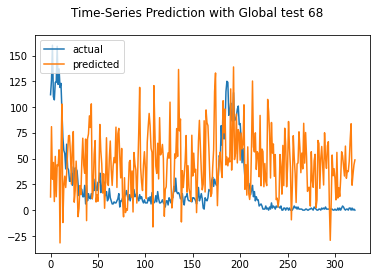

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 43.691
Test RMSE: 51.688
Test sMAPE: 127.169
Test R Squared: -1.592
{'mae': 43.69055624556097, 'rmse': 51.68838177760541, 'smape': 127.16851832667841, 'r2': -1.5920530531379566}


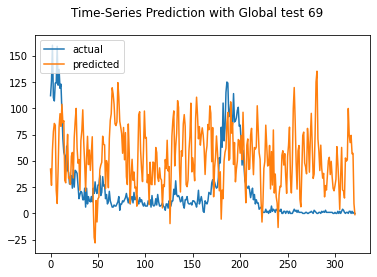

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 39.401
Test RMSE: 49.112
Test sMAPE: 134.608
Test R Squared: -1.340
{'mae': 39.40136356309334, 'rmse': 49.112462437974195, 'smape': 134.60844199295082, 'r2': -1.3401378118845702}


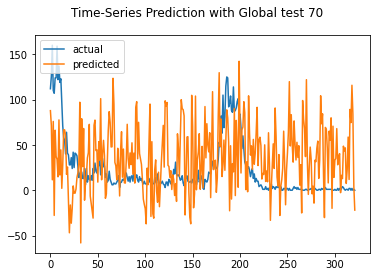

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 39.051
Test RMSE: 45.460
Test sMAPE: 120.807
Test R Squared: -1.005
{'mae': 39.051400383066685, 'rmse': 45.46003429626557, 'smape': 120.80652521185284, 'r2': -1.0050145692068622}


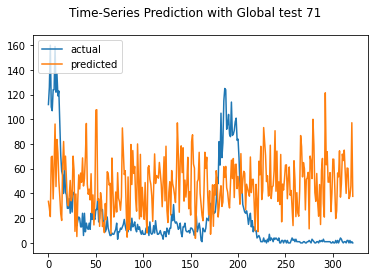

Test MAE: 48.673
Test RMSE: 53.828
Test sMAPE: 129.585
Test R Squared: -1.811
{'mae': 48.67335517362038, 'rmse': 53.82824355167512, 'smape': 129.5853839374439, 'r2': -1.8111138324463565}


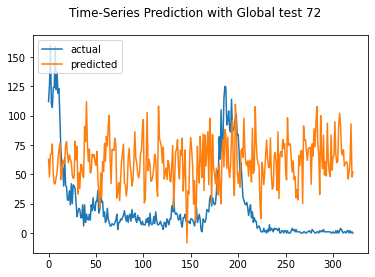

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 45.803
Test RMSE: 53.324
Test sMAPE: 126.268
Test R Squared: -1.759
{'mae': 45.80318866327683, 'rmse': 53.3243370744443, 'smape': 126.26838312248317, 'r2': -1.7587283931264999}


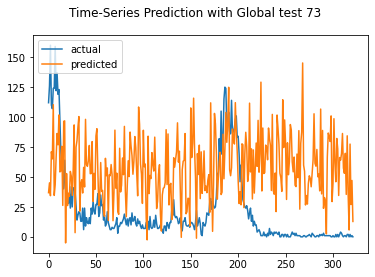

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 37.655
Test RMSE: 50.830
Test sMAPE: 152.831
Test R Squared: -1.507
{'mae': 37.65478964057398, 'rmse': 50.83000852140237, 'smape': 152.83093376500398, 'r2': -1.5066770201760558}


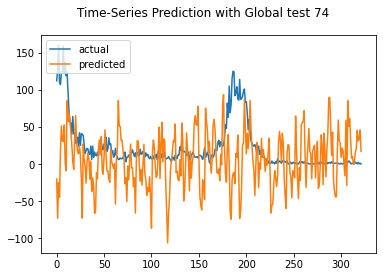

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 41.661
Test RMSE: 55.733
Test sMAPE: 151.852
Test R Squared: -2.014
{'mae': 41.661397037669, 'rmse': 55.73254383846296, 'smape': 151.8517549214734, 'r2': -2.0135315820503337}


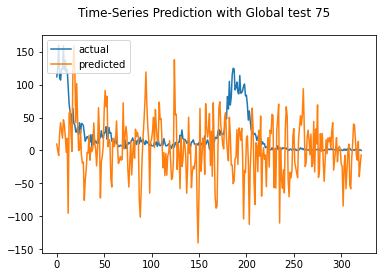

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 40.511
Test RMSE: 51.755
Test sMAPE: 140.342
Test R Squared: -1.599
{'mae': 40.511256022945695, 'rmse': 51.75509029844267, 'smape': 140.34171312890848, 'r2': -1.5987479272447387}


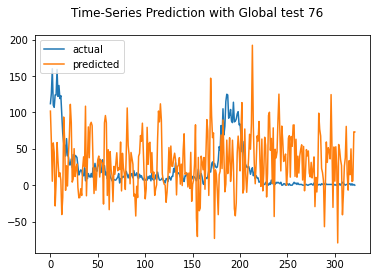

Test MAE: 42.547
Test RMSE: 47.578
Test sMAPE: 126.553
Test R Squared: -1.196
{'mae': 42.5465882570477, 'rmse': 47.57762595977027, 'smape': 126.55318116666558, 'r2': -1.1961578400112667}


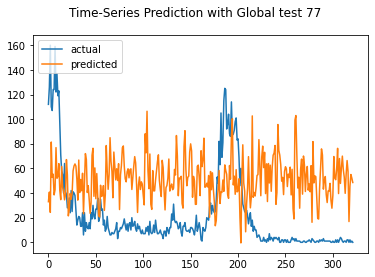

Test MAE: 47.888
Test RMSE: 53.004
Test sMAPE: 129.249
Test R Squared: -1.726
{'mae': 47.88814709571578, 'rmse': 53.003862806203664, 'smape': 129.2493285799982, 'r2': -1.7256686373769257}


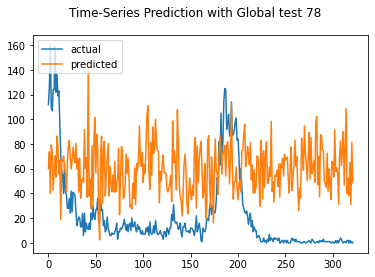

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 46.053
Test RMSE: 53.818
Test sMAPE: 128.904
Test R Squared: -1.810
{'mae': 46.05317192899514, 'rmse': 53.81764636096263, 'smape': 128.90440845694894, 'r2': -1.8100070908900632}


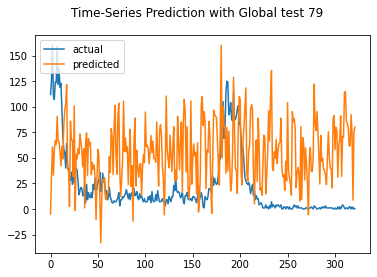

Test MAE: 51.264
Test RMSE: 55.826
Test sMAPE: 131.968
Test R Squared: -2.024
{'mae': 51.26388328786222, 'rmse': 55.82583260026793, 'smape': 131.96842837124578, 'r2': -2.023628516310887}


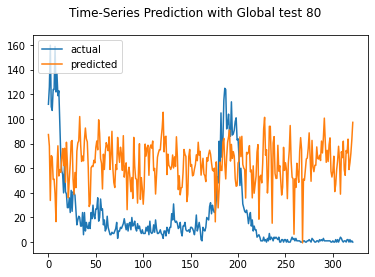

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 43.824
Test RMSE: 51.998
Test sMAPE: 126.297
Test R Squared: -1.623
{'mae': 43.824202687843986, 'rmse': 51.997546518315694, 'smape': 126.29732075209894, 'r2': -1.623153583345117}


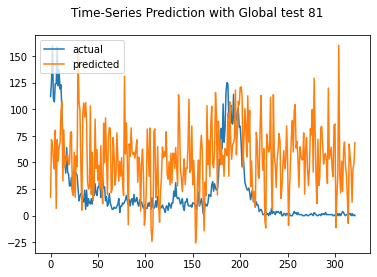

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 38.196
Test RMSE: 44.784
Test sMAPE: 123.367
Test R Squared: -0.946
{'mae': 38.19599999626231, 'rmse': 44.783559306636704, 'smape': 123.3673437331398, 'r2': -0.9457866956711802}


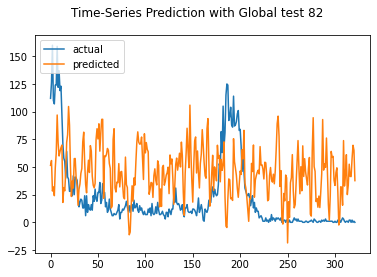

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 45.874
Test RMSE: 51.782
Test sMAPE: 129.385
Test R Squared: -1.601
{'mae': 45.87394930450072, 'rmse': 51.78186641317832, 'smape': 129.38508887706277, 'r2': -1.6014376094545906}


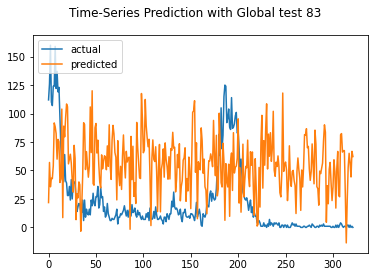

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 41.836
Test RMSE: 54.850
Test sMAPE: 147.498
Test R Squared: -1.919
{'mae': 41.83612890458255, 'rmse': 54.84955582300587, 'smape': 147.497770299424, 'r2': -1.91879937500449}


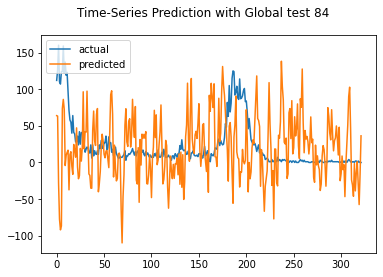

Test MAE: 50.814
Test RMSE: 55.332
Test sMAPE: 132.001
Test R Squared: -1.970
{'mae': 50.81350732886273, 'rmse': 55.332485276122696, 'smape': 132.00118180028002, 'r2': -1.9704234783054613}


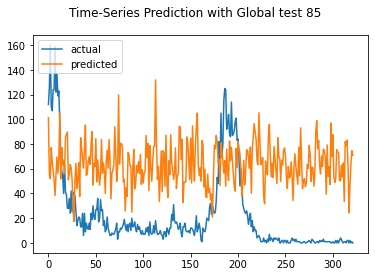

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 36.972
Test RMSE: 47.265
Test sMAPE: 135.306
Test R Squared: -1.167
{'mae': 36.97217457024207, 'rmse': 47.264601833101246, 'smape': 135.30590088856906, 'r2': -1.1673548499887132}


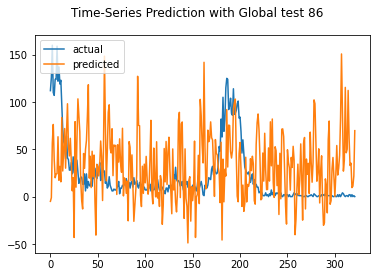

Test MAE: 41.054
Test RMSE: 54.046
Test sMAPE: 132.379
Test R Squared: -1.834
{'mae': 41.053567163322285, 'rmse': 54.04584861249181, 'smape': 132.37928471116695, 'r2': -1.833888086445278}


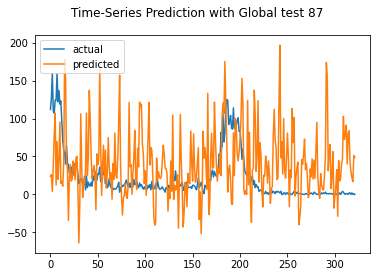

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 39.748
Test RMSE: 51.858
Test sMAPE: 157.383
Test R Squared: -1.609
{'mae': 39.748331094287934, 'rmse': 51.85780977082777, 'smape': 157.383249601004, 'r2': -1.6090737490052316}


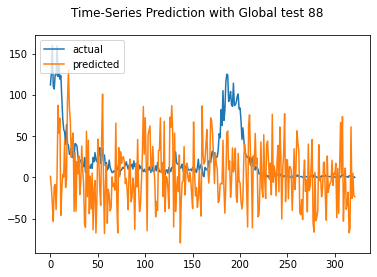

Test MAE: 50.551
Test RMSE: 55.379
Test sMAPE: 130.768
Test R Squared: -1.975
{'mae': 50.55064459320921, 'rmse': 55.37922817241504, 'smape': 130.76786097284105, 'r2': -1.9754442122210882}


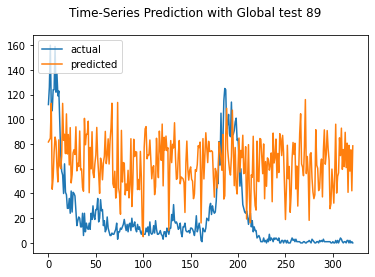

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 36.633
Test RMSE: 50.154
Test sMAPE: 152.998
Test R Squared: -1.440
{'mae': 36.632721988403276, 'rmse': 50.15375687365938, 'smape': 152.99836275861196, 'r2': -1.4404221341507952}


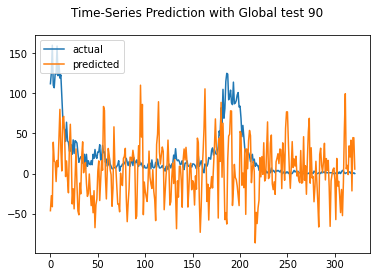

Test MAE: 53.841
Test RMSE: 59.625
Test sMAPE: 133.844
Test R Squared: -2.449
{'mae': 53.841316420284116, 'rmse': 59.625345207721836, 'smape': 133.84424815054732, 'r2': -2.4492115170661193}


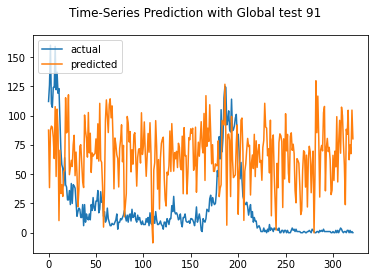

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 46.638
Test RMSE: 53.920
Test sMAPE: 133.460
Test R Squared: -1.821
{'mae': 46.638380004382284, 'rmse': 53.91970459649083, 'smape': 133.46005012062184, 'r2': -1.820674829438151}


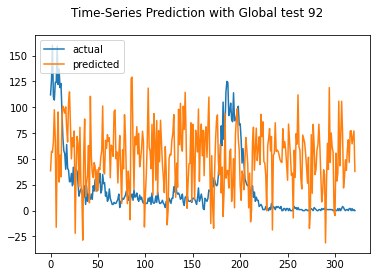

Test MAE: 53.956
Test RMSE: 62.145
Test sMAPE: 134.657
Test R Squared: -2.747
{'mae': 53.955654531347086, 'rmse': 62.14517937496033, 'smape': 134.65740169095943, 'r2': -2.7469069362792014}


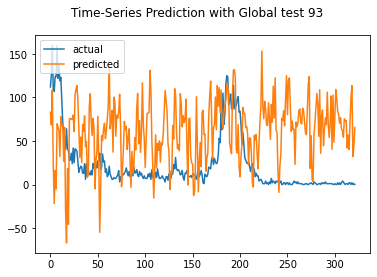

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 41.380
Test RMSE: 52.234
Test sMAPE: 134.578
Test R Squared: -1.647
{'mae': 41.38000293242635, 'rmse': 52.2337911954182, 'smape': 134.57761756136594, 'r2': -1.6470437048352347}


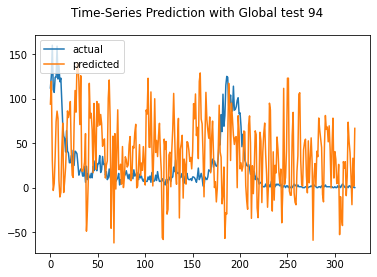

Test MAE: 51.912
Test RMSE: 57.744
Test sMAPE: 131.488
Test R Squared: -2.235
{'mae': 51.9124946831176, 'rmse': 57.74411325717349, 'smape': 131.48815107928908, 'r2': -2.234993763070579}


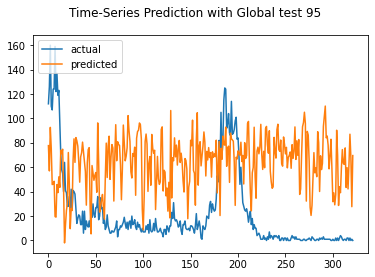

Test MAE: 68.971
Test RMSE: 80.660
Test sMAPE: 144.042
Test R Squared: -5.312
{'mae': 68.97079819274245, 'rmse': 80.66037373023255, 'smape': 144.04207465966246, 'r2': -5.312166914189268}


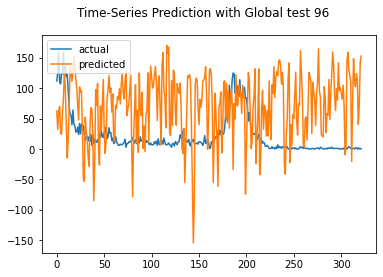

Test MAE: 47.429
Test RMSE: 52.506
Test sMAPE: 128.375
Test R Squared: -1.675
{'mae': 47.4290926104747, 'rmse': 52.50609567074554, 'smape': 128.37473708328915, 'r2': -1.6747147073708564}


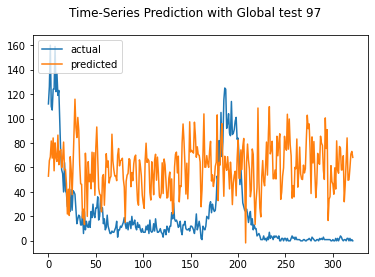

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 42.714
Test RMSE: 49.308
Test sMAPE: 124.820
Test R Squared: -1.359
{'mae': 42.71352380236483, 'rmse': 49.30821650289839, 'smape': 124.82034881146063, 'r2': -1.3588297855475147}


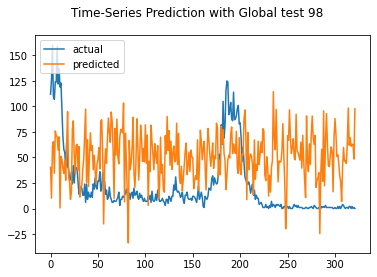

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 40.212
Test RMSE: 52.455
Test sMAPE: 148.804
Test R Squared: -1.670
{'mae': 40.211565838744924, 'rmse': 52.45523462406905, 'smape': 148.80429938447617, 'r2': -1.6695353886827493}


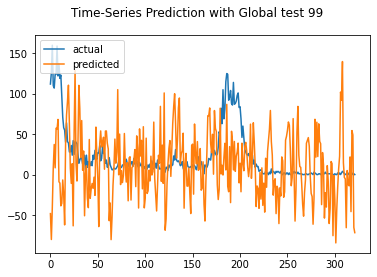

rmse : average=52.850, std=7.052
mae : average=44.245, std=6.275
smape : average=133.216, std=8.787
r2 : average=-1.758, std=0.914


([52.849915977480244, 7.052404744492837],
 [44.24454012361651, 6.274889048376304],
 [133.21582926810078, 8.787183385292389],
 [-1.7581124246310424, 0.9140978835202302])

In [12]:
# Use the Function:
sequence=train_X.shape[1]
features=train_X.shape[2]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
